In [5]:
import torch
import torchvision
import numpy as np
import copy
from cv2 import GaussianBlur
from torch.optim import SGD
from torchvision import models
from PIL import Image, ImageFilter
from torch.autograd import Variable
import matplotlib.pyplot as plt

#Imagenet mean and standard deviation
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess_image(img):
    #normalize the image. img is a numpy array representation of image
    return (img.astype(np.float32)/255.0 - MEAN) / STD

def deprocess_image(img, rescale=False):
    #denormalize i.e x = z*sigma + mu, Multiply each pixel by 255 and clip in range
    img = (img * STD + MEAN)
    return np.clip(255 * img, 0.0, 255.0).astype(np.uint8)


#Function to apply gaussian blur on the image
def blur_image(img):
    kernel = (5, 5)
    img = GaussianBlur(img, kernel, 0.8)
    return img



Synthesizing Regularized Flamingo image ....


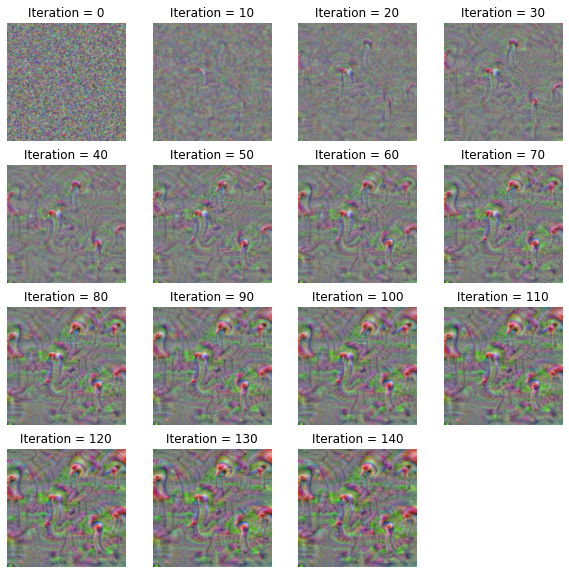

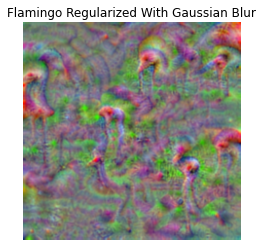

In [6]:
'''
model : pre-trained model we will be using
target_class : target class index for which score needs to be maximized
iterations : Number of iterations.
blur_freq : Frequency of applying Gaussian blur.
lr : Learning rate.
wd: Weight decay for l2 regularization.
rest all are flags for different regularization techniques.
'''
def create_image_to_maximize_class_score(model, target_class, iterations = 150, 
                                         blur_freq = 2, lr = 4 , wd = 0.0001,
                                         blur_enabled = True, clip_pixels = 
                                         True, show_iterations = True):

  #We are using a pretrained network in evaluation mode
  model.eval()

  for param in model.parameters():
    param.requires_grad = False

  #create a zero image / random image at start. Dimension is 224*224*3 i.e H*W*C
  img_arr = preprocess_image(np.random.uniform(0, 255, (224, 224, 3)))

  #Convert the numpy arr to tensor variable
  img_var = torch.from_numpy(img_arr.transpose(2, 0 ,1)).unsqueeze_(
      0).requires_grad_()
  k=1
  plt.figure(figsize=(10,10))
  for i in range(iterations):
    '''
    We will initialize the stochastic gradient descent optim. Parameters are 
    image pixels. Weight decay is for l2 regularization
    '''
    optim = SGD([img_var], lr = lr , weight_decay = wd)

    score = model(img_var)

    #We take negative of score, so that minimizing -ve gives us grad ascent
    loss_fn = -score[0, target_class]
    
    #print(score[0, target_class])

    #compute gradients using backprop and take the step on gradients
    loss_fn.backward()
    
    optim.step()

    #reset image pixels gradients to zero
    img_var.grad.data.zero_()

    #clip pixels within the normalized min and max i.e [norm(0), norm(1)]
    if clip_pixels == True :
      img_var = torch.from_numpy((np.clip(img_var[0].detach().numpy().transpose(
          1, 2, 0), (-MEAN)/STD, (1.0 - MEAN)/STD)).transpose(2, 0, 1)
          ).unsqueeze_(0).requires_grad_()
    
    #use gaussian blur on every alternate iterations
    if blur_enabled == True :
      if(i % blur_freq == 0):
        img = blur_image(img_var[0].detach().numpy().transpose(1, 2, 0))
        img_var = torch.from_numpy(img.transpose(2, 0, 1)).unsqueeze_(
            0).requires_grad_()
    
    if show_iterations == True :
      if(i % 10 == 0):
        img = deprocess_image(img_var[0].detach().numpy(
        ).transpose(1, 2, 0))
        plt.subplot(4,4,k)
        plt.title("Iteration = {}".format(i))
        k+=1
        plt.imshow(img)
        plt.axis('off')
        img_var = torch.from_numpy(preprocess_image(img).transpose(2, 0, 1)
        ).unsqueeze_(0).requires_grad_()
  plt.show()
  if blur_enabled :
    final_img = blur_image(img_var[0].detach().numpy().transpose(1, 2, 0))      
  else :
    final_img = img_var[0].detach().numpy().transpose(1, 2, 0)
  
  return deprocess_image(final_img)


target_class = 130 #Flamingo
vgg16_model = models.vgg16(pretrained = True)
print("Synthesizing Regularized Flamingo image ....")
final_image = create_image_to_maximize_class_score(vgg16_model, target_class)
plt.imshow(final_image)
plt.axis('off')
plt.title('Flamingo Regularized With Gaussian Blur')
plt.show()

Synthesizing Unregularized Flamingo Image


<Figure size 720x720 with 0 Axes>

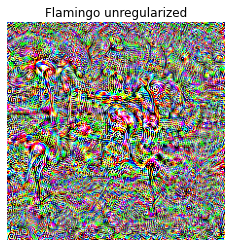

Synthesizing Flamingo image with l2 regularization


<Figure size 720x720 with 0 Axes>

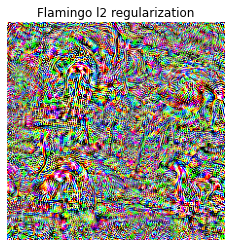

In [7]:
#generate image with no regularization
print("Synthesizing Unregularized Flamingo Image")
final_image_1 = create_image_to_maximize_class_score(vgg16_model, target_class,
                                                   wd = 0, blur_enabled = False,
                                                   clip_pixels = False, 
                                                   show_iterations = False)

plt.imshow(final_image_1)
plt.axis('off')
plt.title('Flamingo unregularized')
plt.show()
print("Synthesizing Flamingo image with l2 regularization")

#generate image with l2 regularization
final_image_2 = create_image_to_maximize_class_score(vgg16_model, target_class,
                                                   wd = 0.0001, blur_enabled = False,
                                                   clip_pixels = False, 
                                                   show_iterations = False)

plt.imshow(final_image_2)
plt.axis('off')
plt.title('Flamingo l2 regularization')

plt.show()

Synthesizing regularized Indian Cobra Image


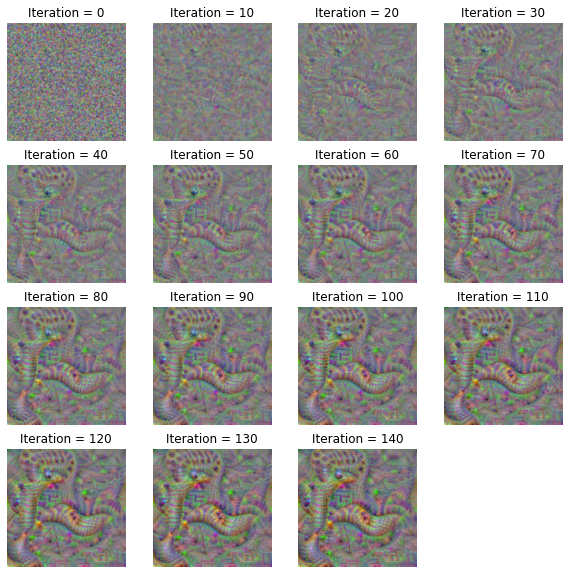

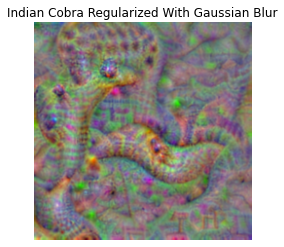

In [8]:
target_class = 63 #Indian cobra
print("Synthesizing regularized Indian Cobra Image")
final_image = create_image_to_maximize_class_score(vgg16_model, target_class)
plt.imshow(final_image)
plt.axis('off')
plt.title('Indian Cobra Regularized With Gaussian Blur')
plt.show()

Synthesizing Unregularized Indian Cobra Image


<Figure size 720x720 with 0 Axes>

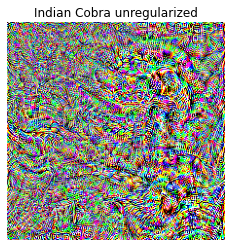

Synthesizing Indian Cobra image with l2 regularization


<Figure size 720x720 with 0 Axes>

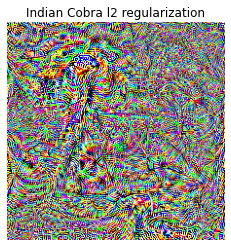

In [9]:
print("Synthesizing Unregularized Indian Cobra Image")
#generate image with no regularization
final_image_1 = create_image_to_maximize_class_score(vgg16_model, target_class,
                                                   wd = 0, blur_enabled = False,
                                                   clip_pixels = False, 
                                                   show_iterations = False)

plt.imshow(final_image_1)
plt.axis('off')
plt.title('Indian Cobra unregularized')
plt.show()

print("Synthesizing Indian Cobra image with l2 regularization")

#generate image with l2 regularization
final_image_2 = create_image_to_maximize_class_score(vgg16_model, target_class,
                                                   wd = 0.0001, blur_enabled = False,
                                                   clip_pixels = False, 
                                                   show_iterations = False)

plt.imshow(final_image_2)
plt.axis('off')
plt.title('Indian Cobra l2 regularization')
plt.show()

Synthesizing regularized Gorilla Image


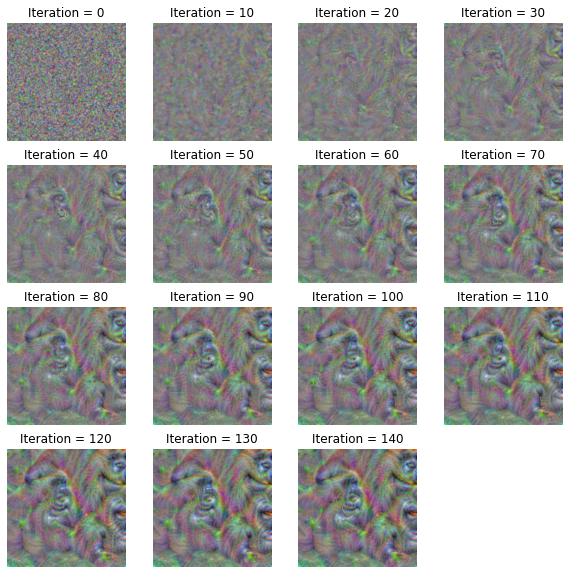

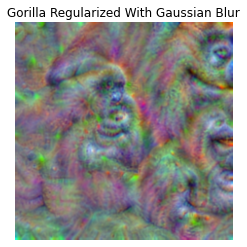

In [10]:
target_class = 366 #Gorilla
print("Synthesizing regularized Gorilla Image")
final_image = create_image_to_maximize_class_score(vgg16_model, target_class)
plt.imshow(final_image)
plt.axis('off')
plt.title('Gorilla Regularized With Gaussian Blur')
plt.show()

Synthesizing Unregularized Gorilla Image


<Figure size 720x720 with 0 Axes>

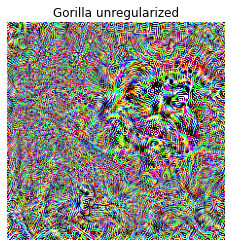

Synthesizing Gorilla image with l2 regularization


<Figure size 720x720 with 0 Axes>

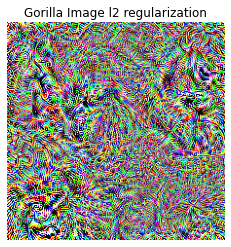

In [11]:
print("Synthesizing Unregularized Gorilla Image")
#generate image with no regularization
final_image_1 = create_image_to_maximize_class_score(vgg16_model, target_class,
                                                   wd = 0, blur_enabled = False,
                                                   clip_pixels = False, 
                                                   show_iterations = False)

plt.imshow(final_image_1)
plt.axis('off')
plt.title('Gorilla unregularized')
plt.show()

print("Synthesizing Gorilla image with l2 regularization")

#generate image with l2 regularization
final_image_2 = create_image_to_maximize_class_score(vgg16_model, target_class,
                                                   wd = 0.0001, blur_enabled = False,
                                                   clip_pixels = False, 
                                                   show_iterations = False)

plt.imshow(final_image_2)
plt.axis('off')
plt.title('Gorilla Image l2 regularization')

plt.show()